In [1]:
# custom layers for both the CNN and the RNN parts of the model. 

Custom CNN Layer
We will create a custom CNN layer to extract features from the images.

In [ ]:
! pip install tensorflow 
! pip install pydot

# not working scratch model from 07/06

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, TimeDistributed
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import os
import tensorflow as tf


2024-06-07 14:16:55.252509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 14:16:56.251217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Data Preparation
Image Preprocessing

In [96]:
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, Embedding, LSTM, add, Input
from tensorflow.keras.models import Model

class CustomCNN(Layer):
    def __init__(self, **kwargs):
        super(CustomCNN, self).__init__(**kwargs)
        self.conv1 = Conv2D(32, (3, 3), activation='relu')
        self.pool1 = MaxPooling2D((2, 2))
        self.conv2 = Conv2D(64, (3, 3), activation='relu')
        self.pool2 = MaxPooling2D((2, 2))
        self.flatten = Flatten()
        self.dense = Dense(256, activation='relu')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

class CustomRNN(Layer):
    def __init__(self, vocab_size, max_length, **kwargs):
        super(CustomRNN, self).__init__(**kwargs)
        self.embedding = Embedding(vocab_size, 256, input_length=max_length, mask_zero=True)
        self.lstm = LSTM(256)

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.lstm(x)
        return x

def define_combined_model(vocab_size, max_length):
    # Image feature extraction model
    inputs1 = Input(shape=(299, 299, 3))
    cnn_out = CustomCNN()(inputs1)
    
    # Sequence model
    inputs2 = Input(shape=(max_length,))
    rnn_out = CustomRNN(vocab_size, max_length)(inputs2)
    
    # Decoder model
    decoder = add([cnn_out, rnn_out])
    decoder = Dense(256, activation='relu')(decoder)
    outputs = Dense(vocab_size, activation='softmax')(decoder)
    
    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

# model = define_combined_model(vocab_size, max_length)
model = define_combined_model(7378, 34)
model.summary()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_133"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_83      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_84      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_cnn          │ (None, 256)       │ 87,329,984 │ input_layer_83[0… │
│ (CustomCNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_rnn          │ (None, 256)       │  2,414,080 │ input_layer_84[0… │
│ (CustomRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_130 (Add)       │ (None, 256)       │          0 │ custom_cnn[0][0], │
│                     │                   │            │ custom_rnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_124 (Dense)   │ (None, 256)       │     65,792 │ add_130[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_125 (Dense)   │ (None, 7378)      │  1,896,146 │ dense_124[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,706,002 (349.83 MB)

 Trainable params: 91,706,002 (349.83 MB)

 Non-trainable params: 0 (0.00 B)

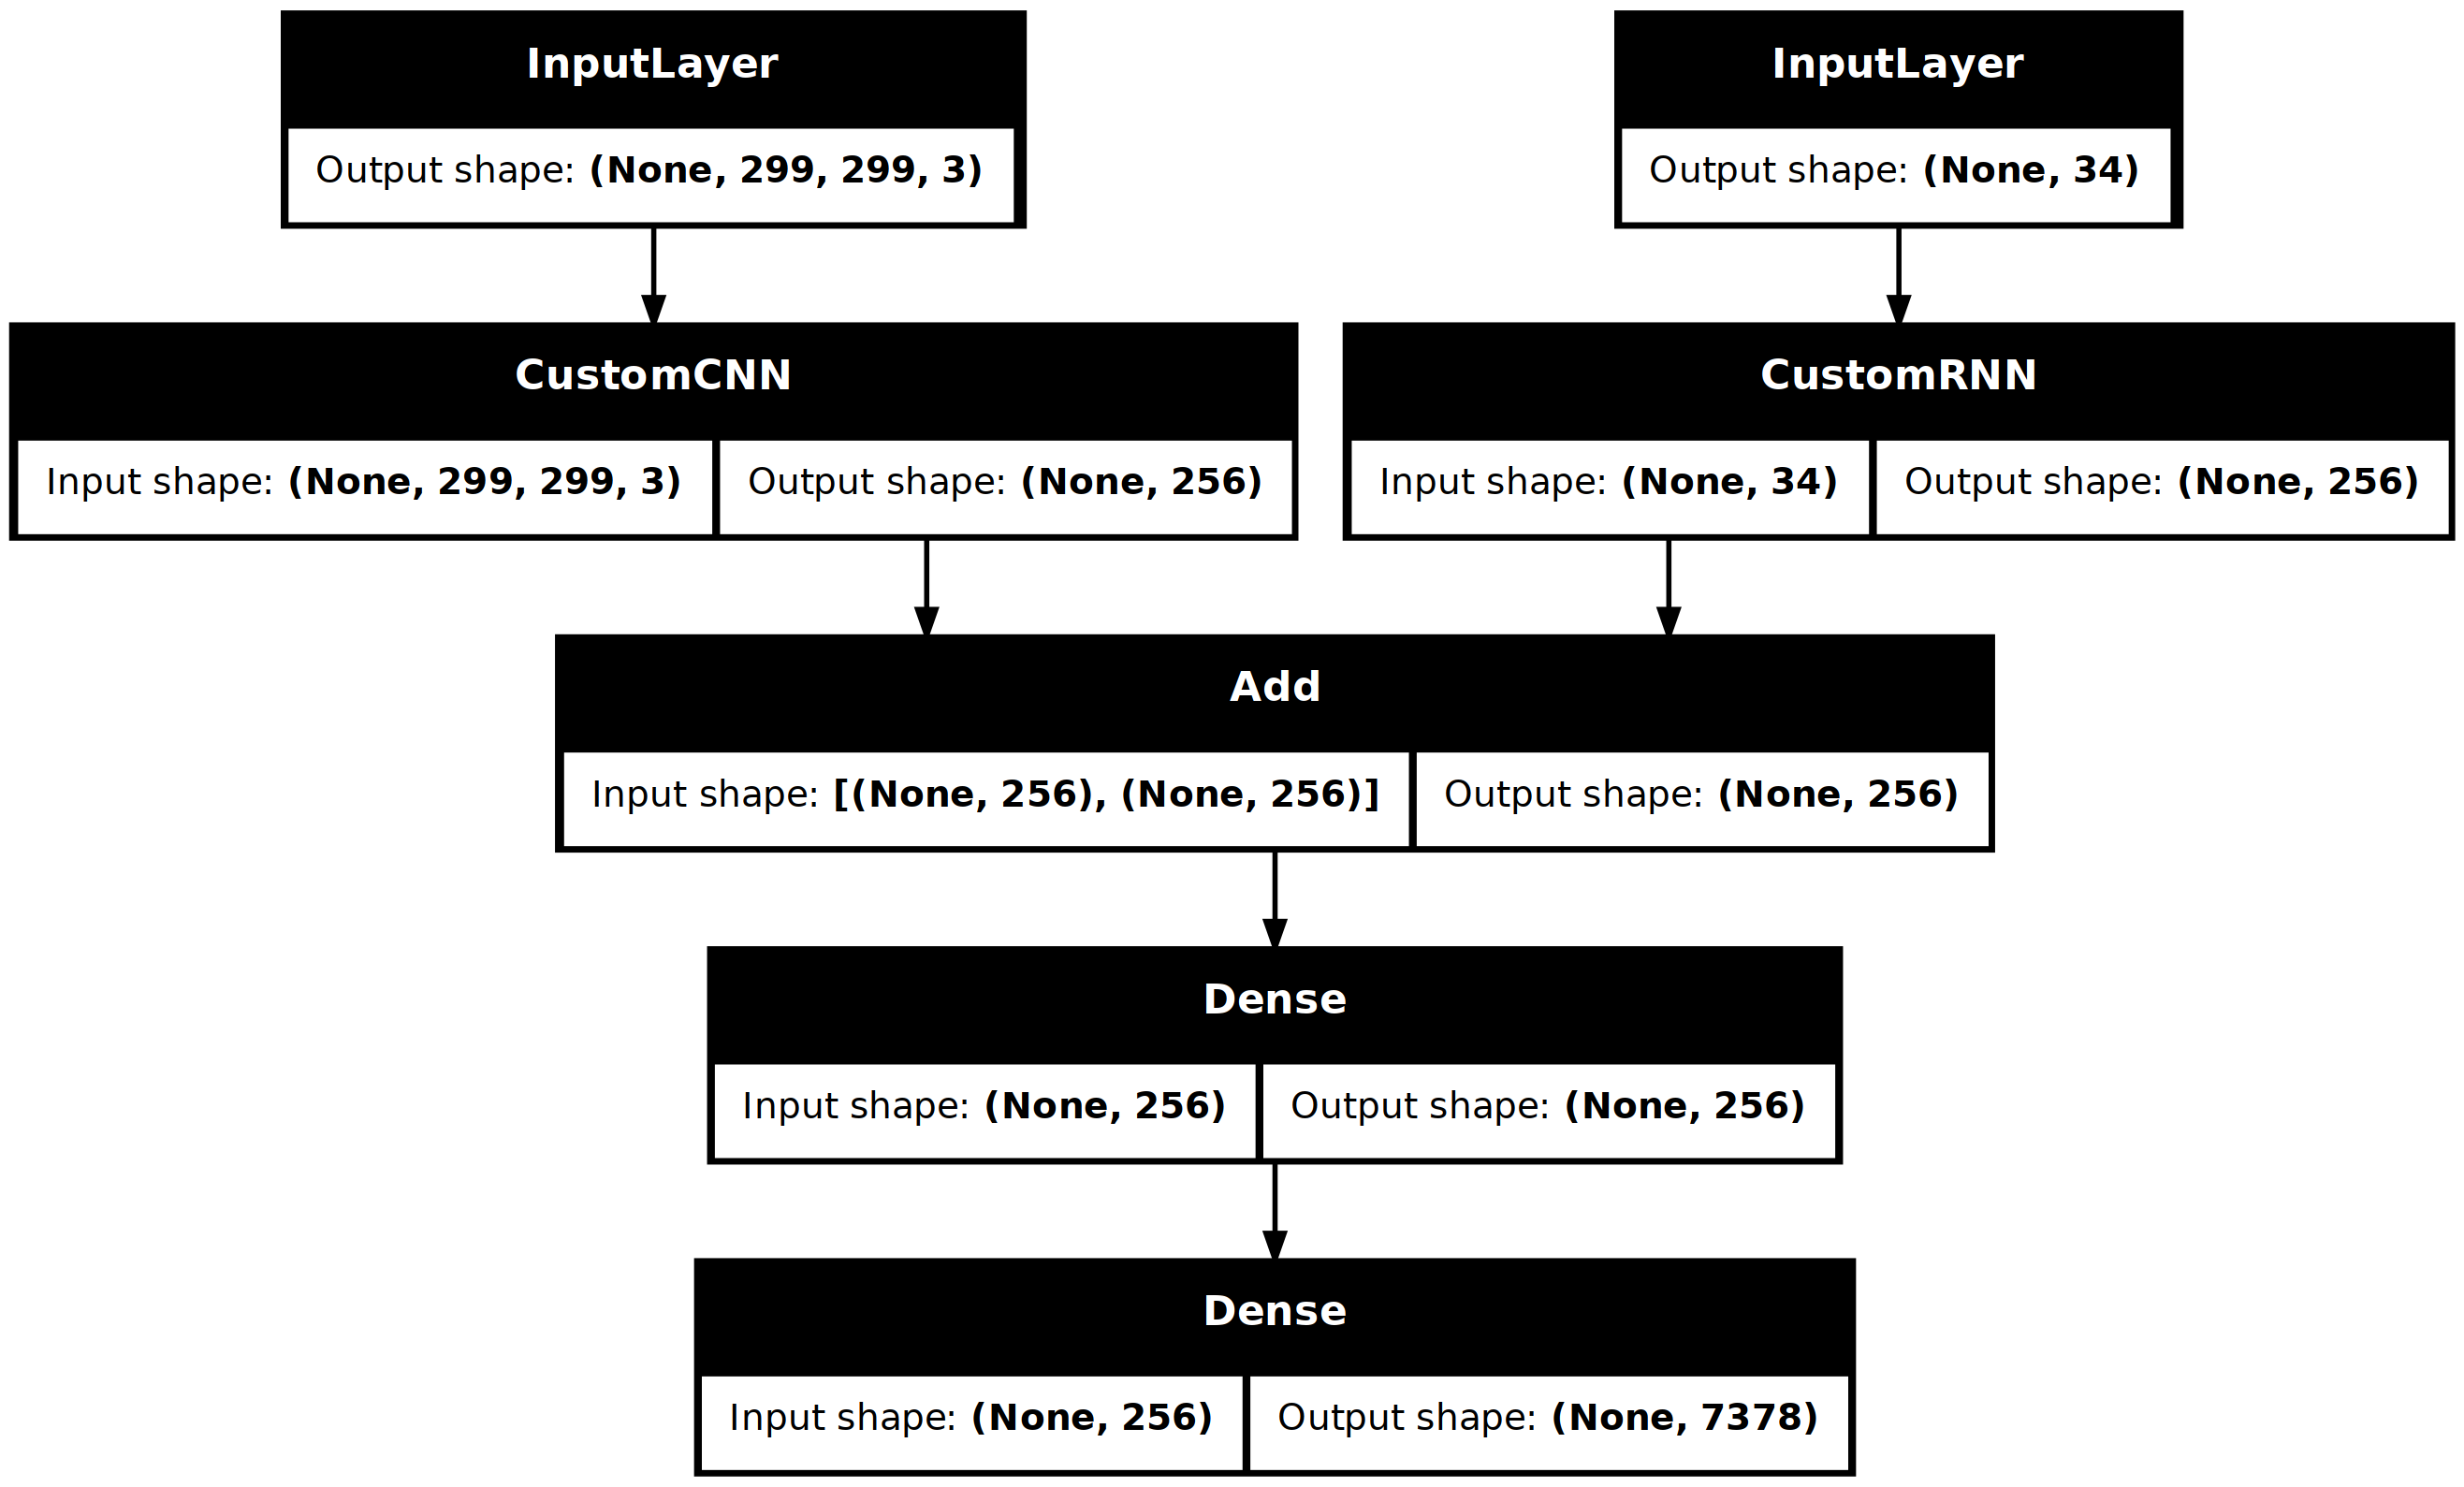

In [5]:
# import tensorflow as tf

tf.keras.utils.plot_model(model,  show_shapes=True)


In [10]:
from classes.dataset_loader import DatasetLoader

current_dir = os.getcwd()
dataset = DatasetLoader().load_data(folder_name=os.path.join(current_dir, 'coco')) 
# datasetloader fatto da cane, 1 squando carichi il DatasetLoader() chiama di default load_data con folder_name = coco... perchè? non ho la possibilità di specificare un altro file path!
# se non c'è la cartella la crea ( commentato bene e apposta)... poi ci legge dentro e Wow non trova il file json :O ... eccezione!
# Non mi chiedere il folder name se poi assumi che la cartella padre sia quella, non è meglio un bel path? magari relativo di default alla cartella os.getcwd()/coco?

# per ora commentato il join dfl_project folder :) e uso direttamente il path, carica 2 volte il dataset




Loading data..
Data loaded succesfully!
Loading data..
Data loaded succesfully!


In [13]:
dataset['annotations']
# [{'image_id': 318556,
#   'id': 48,
#   'caption': 'A very clean and well decorated empty bathroom'},
#  {'image_id': 116100,
#   'id': 67,
#   'caption': 'A panoramic view of a kitchen and all of its appliances.'},
#  {'image_id': 318556,
#   'id': 126,
#   'caption': 'A blue and white bathroom with butterfly themed wall tiles.'},
#  {'image_id': 116100,
#   'id': 148,
#   'caption': 'A panoramic photo of a kitchen and dining room'},
#  {'image_id': 379340,

dataset['images'] # the images are in the folder coco/images
# [{'license': 5,
#   'file_name': 'COCO_train2014_000000057870.jpg',
#   'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
#   'height': 480,
#   'width': 640,
#   'date_captured': '2013-11-14 16:28:13',
#   'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
#   'id': 57870},
#  {'license': 5,
#   'file_name': 'COCO_train2014_000000384029.jpg',
#   'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
#   'height': 429,
#   'width': 640,
#   'date_captured': '2013-11-14 16:29:45',
#   'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
#   'id': 384029},

[{'license': 5,
  'file_name': 'COCO_train2014_000000057870.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 16:28:13',
  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
  'id': 57870},
 {'license': 5,
  'file_name': 'COCO_train2014_000000384029.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000384029.jpg',
  'height': 429,
  'width': 640,
  'date_captured': '2013-11-14 16:29:45',
  'flickr_url': 'http://farm3.staticflickr.com/2422/3577229611_3a3235458a_z.jpg',
  'id': 384029},
 {'license': 1,
  'file_name': 'COCO_train2014_000000222016.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000222016.jpg',
  'height': 640,
  'width': 480,
  'date_captured': '2013-11-14 16:37:59',
  'flickr_url': 'http://farm2.staticflickr.com/1431/1118526611_09172475e5_z.jpg',
  'id': 222016},
 {'license': 3

In [15]:
import json
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from classes.dataset_loader import DatasetLoader

# Load the dataset
dataset = DatasetLoader().load_data(folder_name=os.path.join(os.getcwd(), 'coco'))

# Create a mapping from image_id to file_name
image_id_to_file_name = {image['id']: image['file_name'] for image in dataset['images']}

# Create a mapping from image_id to captions
image_id_to_captions = {}
for annotation in dataset['annotations']:
    image_id = annotation['image_id']
    caption = annotation['caption']
    if image_id not in image_id_to_captions:
        image_id_to_captions[image_id] = []
    image_id_to_captions[image_id].append(caption)

# Create a combined dictionary with image file names and their corresponding captions
file_name_to_captions = {image_id_to_file_name[image_id]: captions 
                         for image_id, captions in image_id_to_captions.items()}


Loading data..
Data loaded succesfully!
Loading data..
Data loaded succesfully!


In [16]:
file_name_to_captions

{'COCO_train2014_000000318556.jpg': ['A very clean and well decorated empty bathroom',
  'A blue and white bathroom with butterfly themed wall tiles.',
  'A bathroom with a border of butterflies and blue paint on the walls above it.',
  'An angled view of a beautifully decorated bathroom.',
  'A clock that blends in with the wall hangs in a bathroom. '],
 'COCO_train2014_000000116100.jpg': ['A panoramic view of a kitchen and all of its appliances.',
  'A panoramic photo of a kitchen and dining room',
  'A wide angle view of the kitchen work area',
  'multiple photos of a brown and white kitchen. ',
  'A kitchen that has a checkered patterned floor and white cabinets.'],
 'COCO_train2014_000000379340.jpg': ['A graffiti-ed stop sign across the street from a red car ',
  'A vandalized stop sign and a red beetle on the road',
  'A red stop sign with a Bush bumper sticker under the word stop.',
  'A stop sign that has been vandalized is pictured in front of a parked car.',
  'A street sign 

In [29]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

def load_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = preprocess_input(img)
    return img

def data_generator(file_name_to_captions, image_directory, tokenizer, max_length, vocab_size):
    while True:
        for file_name, captions in file_name_to_captions.items():
            img_path = os.path.join(image_directory, file_name)
            img = load_image(img_path)
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    yield [img, in_seq], out_seq

def create_tf_data_generator(file_name_to_captions, image_directory, tokenizer, max_length, vocab_size, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(file_name_to_captions, image_directory, tokenizer, max_length, vocab_size),
        output_signature=(
            (tf.TensorSpec(shape=(299, 299, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(max_length,), dtype=tf.int32)),
            tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [35]:
# Set parameters
vocab_size = 10000  # Adjust according to your vocabulary size
max_length = 34     # Adjust according to your max caption length
batch_size = 64

# Tokenize captions
tokenizer = Tokenizer(num_words=vocab_size)
all_captions = [caption for captions in file_name_to_captions.values() for caption in captions]
tokenizer.fit_on_texts(all_captions)

image_directory = 'coco/train2014/'

train_dataset = create_tf_data_generator(file_name_to_captions, image_directory, tokenizer, max_length, vocab_size, batch_size)


In [38]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception

def define_model(vocab_size, max_length):
    # Image feature extractor model
    image_input = Input(shape=(299, 299, 3))
    base_model = Xception(include_top=False, pooling='avg')(image_input)
    image_features = Dense(256, activation='relu')(base_model)
    
    # Sequence model
    text_input = Input(shape=(max_length,))
    text_embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)
    text_dropout = Dropout(0.5)(text_embedding)
    text_lstm = LSTM(256)(text_dropout)
    
    # Decoder model
    decoder = add([image_features, text_lstm])
    decoder_dense = Dense(256, activation='relu')(decoder)
    outputs = Dense(vocab_size, activation='softmax')(decoder_dense)
    
    model = Model(inputs=[image_input, text_input], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = define_model(vocab_size, max_length)
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 34, 256)   │  2,560,000 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xception            │ (None, 2048)      │ 20,861,480 │ input_layer_17[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 34, 256)   │          0 │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 34)        │          0 │ input_layer_19[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    524,544 │ xception[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 256)       │    525,312 │ dropout_5[0][0],  │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_78 (Add)        │ (None, 256)       │          0 │ dense_18[0][0],   │
│                     │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │     65,792 │ add_78[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 10000)     │  2,570,000 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,107,128 (103.41 MB)

 Trainable params: 27,052,600 (103.20 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [37]:
steps = len(file_name_to_captions) // batch_size
model.fit(train_dataset, epochs=20, steps_per_epoch=steps, verbose=1)


Epoch 1/20


ValueError: Layer 'functional_11' expected 2 input(s). Received 1 instead.

In [41]:
from data_loader import get_loader
from pycocotools.coco import COCO
from torchvision import transforms

# Amend the image transform below.
transform_train = transforms.Compose(
    [
        # smaller edge of image resized to 256
        transforms.Resize(256),
        # get 224x224 crop from random location
        transforms.RandomCrop(224),
        # horizontally flip image with probability=0.5
        transforms.RandomHorizontalFlip(),
        # convert the PIL Image to a tensor
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)

[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
make 

In [ ]:

# Build data loader.
data_loader = get_loader(
    transform=transform_train,
    mode="train",
    batch_size=batch_size,
    vocab_threshold=5,
    vocab_from_file=False,
    cocoapi_loc="",
)

# 08 - 06 | Using load dataset code form new_model

# Load and prepare the data

## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

2024-06-08 14:50:07.482455: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 14:50:10.504993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Download the dataset

We will be using the Flickr8K dataset for this tutorial. This dataset comprises over
8,000 images, that are each paired with five different captions.

In [2]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

## Preparing the dataset

In [3]:
import json
import os
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from fdl_project.classes.dataset_loader import DatasetLoader

# Load the dataset
dataset = DatasetLoader().load_data(folder_name=os.path.join(os.getcwd(), "coco"))

Loading data..
Data loaded succesfully!
Loading data..
Data loaded succesfully!


In [4]:
def load_captions_data(dataset):
    text_annotations = []

    # Create a mapping from image_id to file_name
    image_id_to_file_name = {image["id"]: image["file_name"] for image in dataset["images"]}

    # Create a mapping from image_id to captions
    image_id_to_captions = {}
    for annotation in dataset["annotations"]:
        image_id = annotation["image_id"]
        caption = "<start> " + annotation["caption"] + " <end>"

        if image_id not in image_id_to_captions:
            image_id_to_captions[image_id] = []

        image_id_to_captions[image_id].append(caption)
        text_annotations.append(caption)

    # Create a combined dictionary with image file names and their corresponding captions
    file_name_to_captions = {
        image_id_to_file_name[image_id]: captions
        for image_id, captions in image_id_to_captions.items()
    }

    return file_name_to_captions, text_annotations


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

# Load the dataset
captions_mapping, text_data = load_captions_data(dataset)

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  66226
Number of validation samples:  16557


In [5]:
# captions_mapping
for key, value in train_data.items():
    if len(value) > 5:
        print(key, len(value))
        train_data[key] = value[:5]

print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

COCO_train2014_000000254362.jpg 6
COCO_train2014_000000372510.jpg 6
COCO_train2014_000000197827.jpg 6
COCO_train2014_000000080739.jpg 6
COCO_train2014_000000183646.jpg 6
COCO_train2014_000000473462.jpg 6
COCO_train2014_000000206042.jpg 6
COCO_train2014_000000141510.jpg 6
COCO_train2014_000000079701.jpg 6
COCO_train2014_000000572061.jpg 6
COCO_train2014_000000182933.jpg 6
COCO_train2014_000000018748.jpg 6
COCO_train2014_000000543058.jpg 6
COCO_train2014_000000136015.jpg 6
COCO_train2014_000000234396.jpg 6
COCO_train2014_000000533228.jpg 6
COCO_train2014_000000232490.jpg 6
COCO_train2014_000000105529.jpg 6
COCO_train2014_000000002193.jpg 6
COCO_train2014_000000280508.jpg 6
COCO_train2014_000000353400.jpg 6
COCO_train2014_000000267152.jpg 6
COCO_train2014_000000088005.jpg 6
COCO_train2014_000000125394.jpg 6
COCO_train2014_000000431555.jpg 6
COCO_train2014_000000104006.jpg 6
COCO_train2014_000000387901.jpg 6
COCO_train2014_000000302071.jpg 6
COCO_train2014_000000052650.jpg 6
COCO_train2014

## Vectorizing the text data

We'll use the `TextVectorization` layer to vectorize the text data,
that is to say, to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary. We will use a custom string standardization scheme
(strip punctuation characters except `<` and `>`) and the default
splitting scheme (split on whitespace).

In [6]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


## Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a `tf.data.Dataset` object.
The pipeline consists of two steps:

1. Read the image from the disk
2. Tokenize all the five captions corresponding to the image

In [7]:
# append coco/train2014/ to all the keys of the dictionary

train_data = {
    os.path.join("coco/train2014/", key): value for key, value in train_data.items()
}

In [8]:

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, tf.ragged.constant((captions))))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


In [9]:
# def decode_and_resize(img_path):
#     img = tf.io.read_file(img_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, IMAGE_SIZE)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     return img

# def vectorize_caption(caption):
#     # Assuming `vectorization` is a function that converts text to integer sequences
#     return vectorization(caption)

# def process_input(img_path, captions):
#     image = decode_and_resize(img_path)
#     captions = [vectorize_caption(c) for c in captions]
#     captions = [pad_or_truncate_caption(c) for c in captions]
#     captions = tf.convert_to_tensor(captions)
#     return image, captions

# def make_dataset(images, captions):
    
#     return dataset


In [10]:
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

# def define_custom_cnn(input_shape):
#     inputs = Input(shape=input_shape)
#     x = Conv2D(32, (3, 3), activation='relu')(inputs)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(64, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(128, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(256, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Flatten()(x)
#     x = Dense(256, activation='relu')(x)
#     model = Model(inputs, x)
#     return model


In [11]:
# from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications.xception import Xception

# def define_model(vocab_size, max_length, input_shape=(299, 299, 3), compile=True):
#     # Custom CNN model
#     cnn_model = define_custom_cnn(input_shape)
#     image_input = cnn_model.input
#     image_features = cnn_model.output
    
#     # Sequence model
#     text_input = Input(shape=(max_length,))
#     text_embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)
#     text_dropout = Dropout(0.5)(text_embedding)
#     text_lstm = LSTM(256)(text_dropout)
    
#     # Decoder model
#     decoder = add([image_features, text_lstm])
#     decoder_dense = Dense(256, activation='relu')(decoder)
#     outputs = Dense(vocab_size, activation='softmax')(decoder_dense)
    
#     model = Model(inputs=[image_input, text_input], outputs=outputs)
#     if compile:
#         model.compile(loss='categorical_crossentropy', optimizer='adam')
    
#     return model

# model = define_model(VOCAB_SIZE, SEQ_LENGTH, compile=True)
# model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 297, 297,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 148, 148,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 146, 146,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 73, 73,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 71, 71,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 35, 35,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 33, 33,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 25, 256)   │  2,560,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 65536)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 25, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 25)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 16,777,472 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout[0][0],    │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]       

 Total params: 22,886,992 (87.31 MB)

 Trainable params: 22,886,992 (87.31 MB)

 Non-trainable params: 0 (0.00 B)

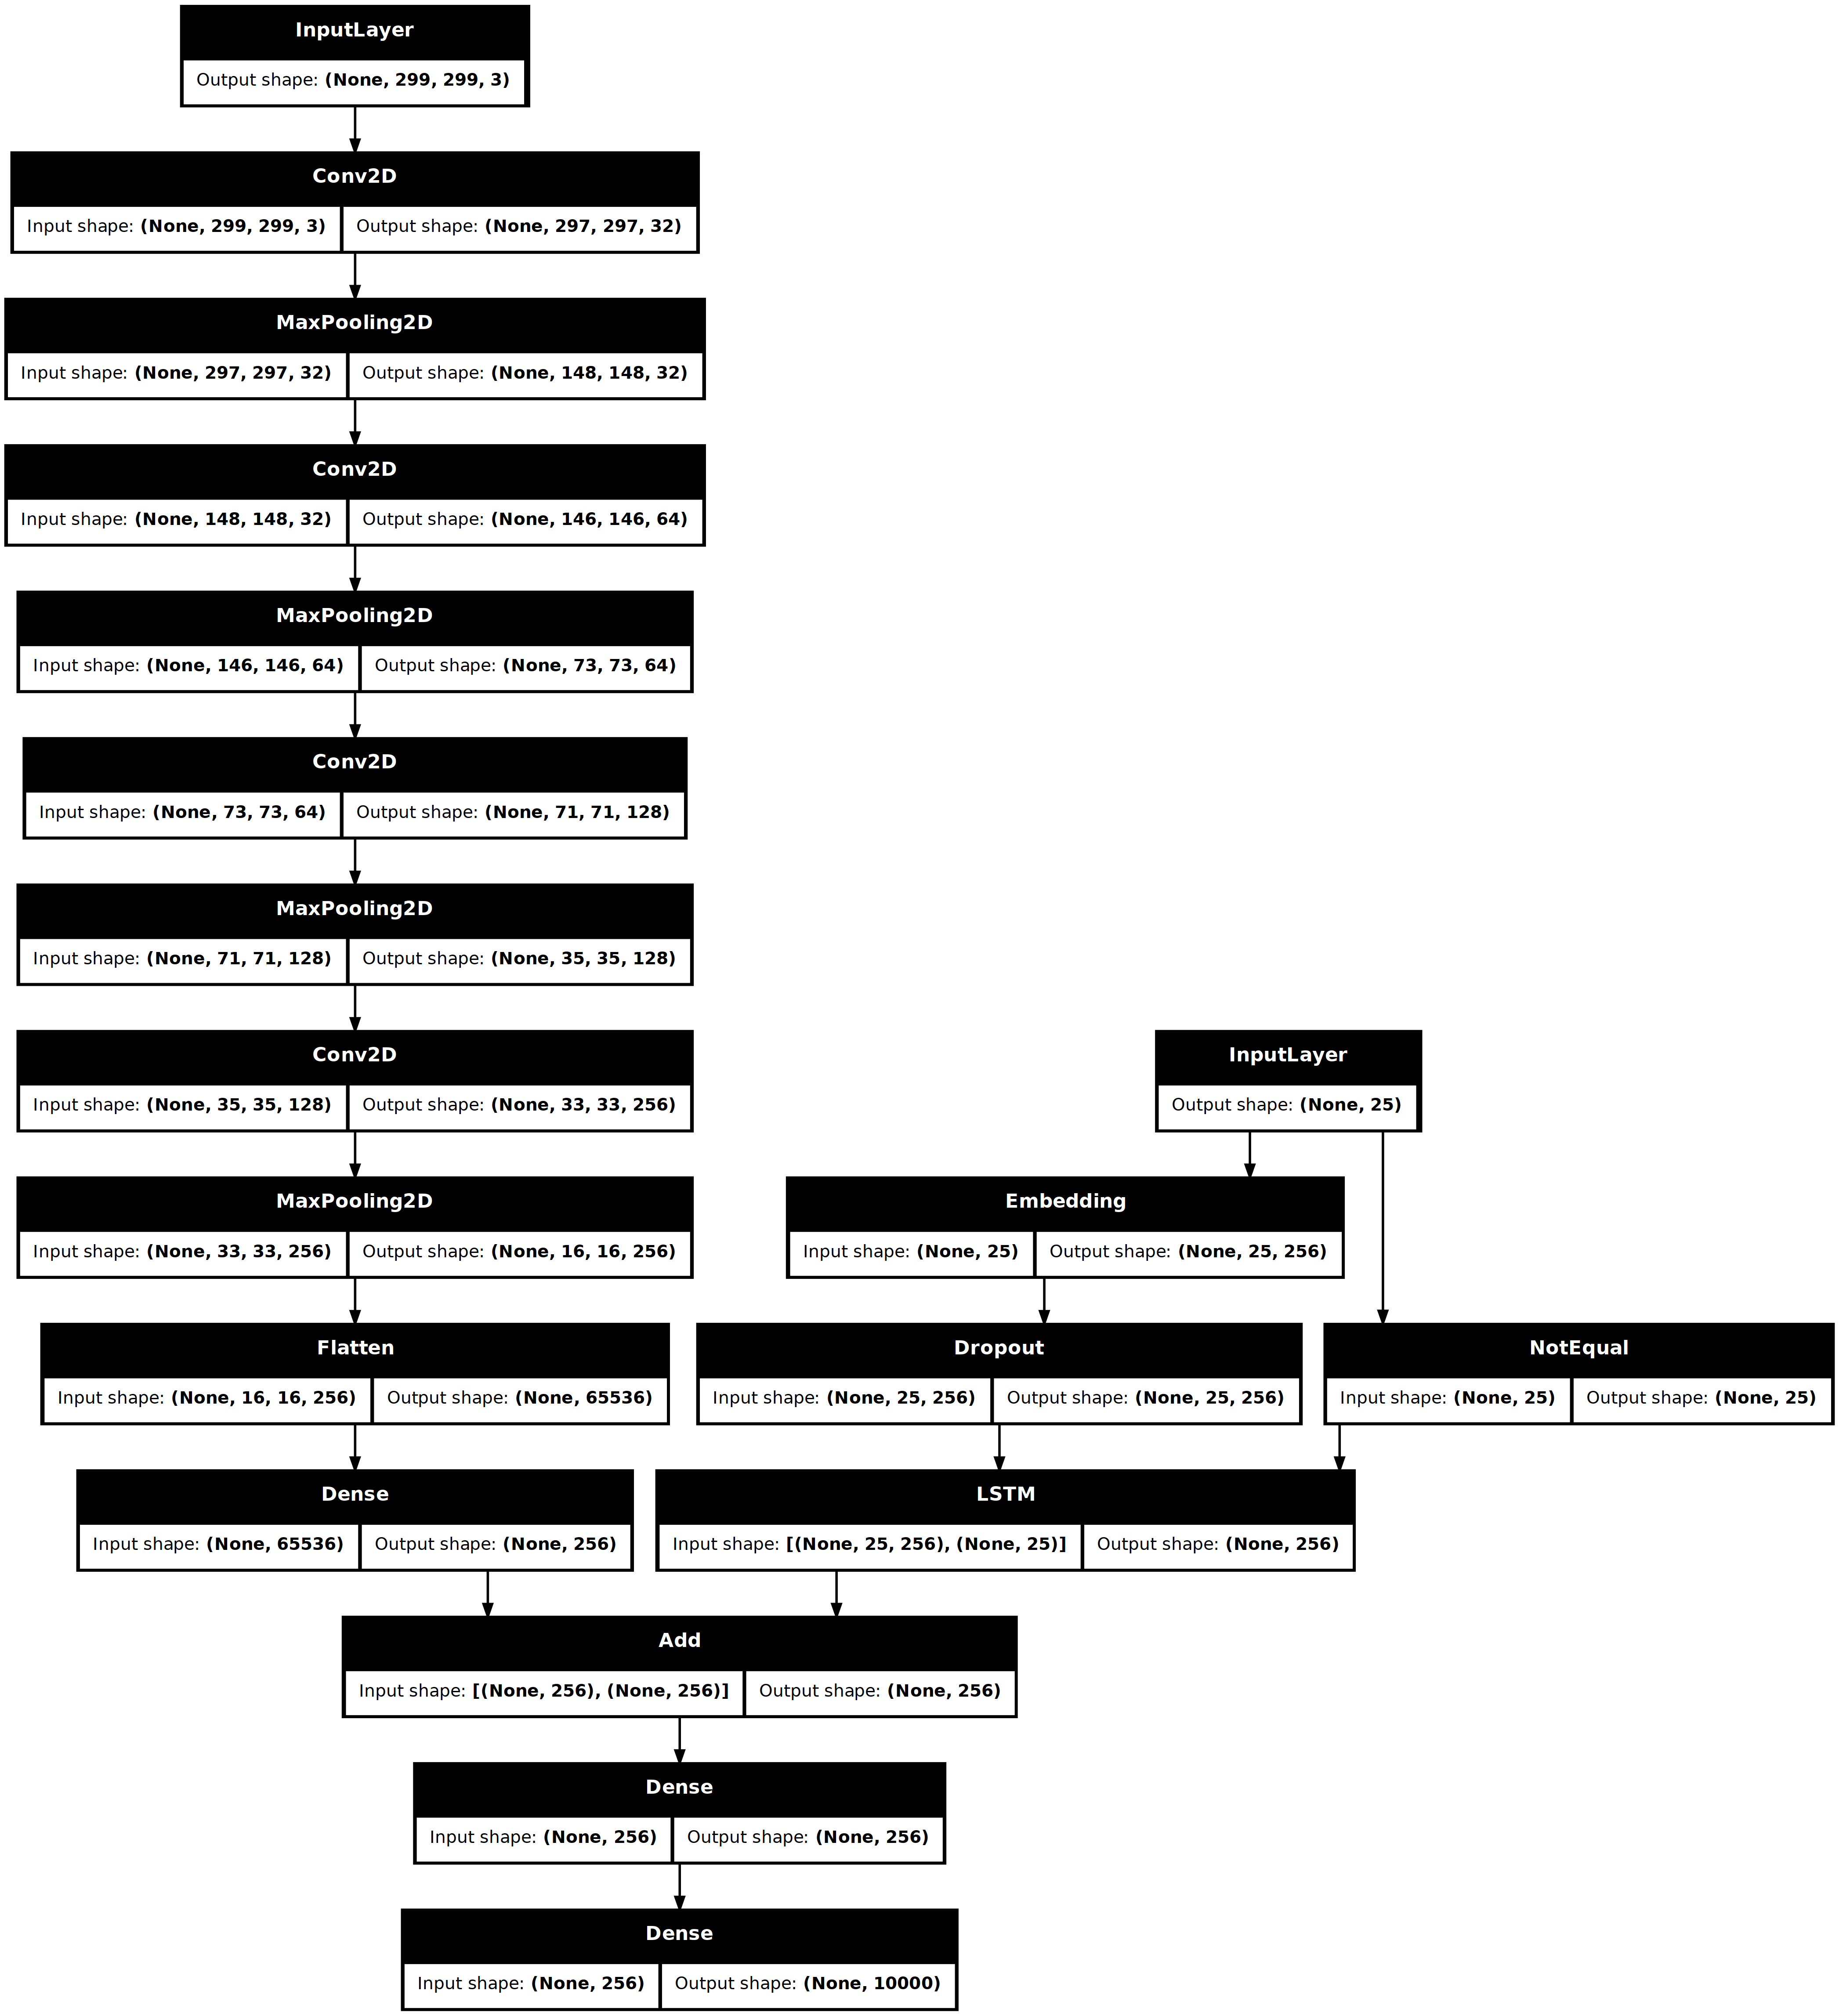

In [12]:
# from tensorflow import keras
# keras.utils.plot_model(model,  show_shapes=True)

In [13]:
# # # BATCH_SIZE = 64
# # # EPOCHS = 30
# # steps = len(file_name_to_captions) // batch_size
# # model.fit(train_dataset, epochs=20, steps_per_epoch=steps, verbose=1)

# steps = len(train_data) // BATCH_SIZE
# model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps, verbose=1)


In [14]:

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction=None,
)

# # EarlyStopping criteria
# early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# caption_model = define_model(VOCAB_SIZE, SEQ_LENGTH, compile=False)
# # Compile the model
# caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)
# keras.utils.plot_model(caption_model)
# # Fit the model


# caption_model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data=valid_dataset,
#     callbacks=[early_stopping])

#  Layer 'functional_7' expected 2 input(s). Received 1 instead. || LSTM layer problems (the layer name functional_7 is random)

Epoch 1/30


ValueError: Layer 'functional_7' expected 2 input(s). Received 1 instead.

# Encoder decoder definition based on 'new_model' architecture

In [15]:

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)
caption_model.summary()

Model: "image_captioning_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_9 (Functional)       │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_block       │ ?                      │   0 (unbuilt) │
│ (TransformerEncoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_block       │ ?                      │   0 (unbuilt) │
│ (TransformerDecoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [16]:
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
# from tensorflow.keras.models import Model

# def get_cnn_model(input_shape=(299, 299, 3)):
#     inputs = Input(shape=input_shape)
#     x = Conv2D(32, (3, 3), activation='relu')(inputs)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(64, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(128, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Conv2D(256, (3, 3), activation='relu')(x)
#     x = MaxPooling2D((2, 2))(x)
#     x = Flatten()(x)
#     x = Dense(256, activation='relu')(x)
#     model = Model(inputs, x)
#     return model


In [17]:
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Add
# from tensorflow.keras.models import Model

# class LSTMDecoder(Model):
#     def __init__(self, vocab_size, embed_dim, lstm_units):
#         super(LSTMDecoder, self).__init__()
#         self.embedding = Embedding(vocab_size, embed_dim, mask_zero=True)
#         self.lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
#         self.dense1 = Dense(256, activation='relu')
#         self.dense2 = Dense(vocab_size, activation='softmax')

#     def call(self, inputs, encoder_output, training=False, mask=None):
#         embeddings = self.embedding(inputs)
#         lstm_output, state_h, state_c = self.lstm(embeddings, initial_state=[encoder_output, encoder_output])
#         print(f"[lstm log] _output.shape {lstm_output.shape} ;; encoder_output.shape {encoder_output.shape}")
#         lstm_output = Add()([lstm_output, encoder_output])
#         lstm_output = self.dense1(lstm_output)
#         output = self.dense2(lstm_output)
#         return output, state_h, state_c

# # def call(self, inputs, training=False, mask=None):
# #         captions, state_h, state_c = inputs
# #         embeddings = self.embedding(captions)
# #         lstm_output, state_h, state_c = self.lstm(embeddings, initial_state=[state_h, state_c])
# #         lstm_output = Add()([lstm_output, state_h])
# #         lstm_output = self.dense1(lstm_output)
# #         output = self.dense2(lstm_output)
# #         return output, state_h, state_c


In [18]:
from tensorflow.keras import layers, models, losses, optimizers
import tensorflow as tf

class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred, _, _ = self.decoder(batch_seq_inp, encoder_out, training=training, mask=mask)
        # batch_seq_pred = self.decoder(
        #     batch_seq_inp, encoder_out, training=training, mask=mask
        # )
        
        ## from the decoder call lstm
        # def call(self, inputs, encoder_output, training=False, mask=None):
        # captions, state_h, state_c = inputs
        # embeddings = self.embedding(captions)
        # lstm_output, state_h, state_c = self.lstm(embeddings, initial_state=[encoder_output, encoder_output])
        # lstm_output = Add()([lstm_output, encoder_output])
        # lstm_output = self.dense1(lstm_output)
        # output = self.dense2(lstm_output)
        # return output, state_h, state_c
        
        
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

# Example usage
IMAGE_SIZE = (299, 299)
EMBED_DIM = 256
VOCAB_SIZE = 10000  # Example value
SEQ_LENGTH = 34     # Example value
FF_DIM = 256
NUM_HEADS = 2

cnn_model = get_cnn_model(input_shape=(*IMAGE_SIZE, 3))
encoder = Dense(256, activation='relu')  # Simple encoder for compatibility
decoder = LSTMDecoder(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, lstm_units=256)
image_augmentation = None  # Define your image augmentation if any

caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

print(caption_model.summary())


Model: "image_captioning_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_11 (Functional)      │ ?                      │    17,165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_decoder (LSTMDecoder)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,165,888 (65.48 MB)

 Trainable params: 17,165,888 (65.48 MB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:

# # Define the loss function
# cross_entropy = keras.losses.SparseCategoricalCrossentropy(
#     from_logits=False,
#     reduction=None,
# )

# # EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# # Learning Rate Scheduler for the optimizer
# class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
#     def __init__(self, post_warmup_learning_rate, warmup_steps):
#         super().__init__()
#         self.post_warmup_learning_rate = post_warmup_learning_rate
#         self.warmup_steps = warmup_steps

#     def __call__(self, step):
#         global_step = tf.cast(step, tf.float32)
#         warmup_steps = tf.cast(self.warmup_steps, tf.float32)
#         warmup_progress = global_step / warmup_steps
#         warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
#         return tf.cond(
#             global_step < warmup_steps,
#             lambda: warmup_learning_rate,
#             lambda: self.post_warmup_learning_rate,
#         )


# Create a learning rate schedule
# num_train_steps = len(train_dataset) * EPOCHS
# num_warmup_steps = num_train_steps // 15
# lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# # Compile the model
# caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)
[lstm log] _output.shape (64, None, 256) ;; encoder_output.shape (64, 256)


2024-06-08 14:51:56.701939: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 722608128 exceeds 10% of free system memory.
2024-06-08 14:51:59.578249: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 655360000 exceeds 10% of free system memory.
2024-06-08 14:52:00.584126: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 655360000 exceeds 10% of free system memory.
2024-06-08 14:52:01.493399: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 655360000 exceeds 10% of free system memory.
2024-06-08 14:52:02.577812: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 655360000 exceeds 10% of free system memory.


   7/1034 ━━━━━━━━━━━━━━━━━━━━ 2:03:54 7s/step - acc: 0.0000e+00 - loss: 46.9205

KeyboardInterrupt: 

Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [6,25], [batch]: [5,25]
	 [[{{node IteratorGetNext}}]] [Op:__inference_one_step_on_iterator_96533]

Is not a problem related to the architecture but to the dataset. The dataset is not being correctly loaded. This occur also in new_model.